# Advanced Neural Machine Translation Example

In [0]:
# Install TensorFlow and also our package via PyPI
!pip install tensorflow-gpu==2.0.0
!pip install headliner

     |████████████████████████████████| 380.8MB 79kB/s 
     |████████████████████████████████| 450kB 41.6MB/s 
     |████████████████████████████████| 3.8MB 30.9MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0rc3 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
     |████████████████████████████████| 51kB 3.8MB/s 


In [0]:
# Download the German-English sentence pairs
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip

--2019-10-11 07:44:52--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4541707 (4.3M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   4.33M  17.0MB/s    in 0.3s    

2019-10-11 07:44:52 (17.0 MB/s) - ‘deu-eng.zip’ saved [4541707/4541707]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [0]:
# Create the dataset but only take a subset for faster training
import io

def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[w for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs)

eng, ger = create_dataset('deu.txt', 30000)
data = list(zip(ger, eng))
data[:10]

[('Hallo!', 'Hi.'),
 ('Grüß Gott!', 'Hi.'),
 ('Lauf!', 'Run!'),
 ('Potzdonner!', 'Wow!'),
 ('Donnerwetter!', 'Wow!'),
 ('Feuer!', 'Fire!'),
 ('Hilfe!', 'Help!'),
 ('Zu Hülf!', 'Help!'),
 ('Stopp!', 'Stop!'),
 ('Warte!', 'Wait!')]

In [0]:
# Split the dataset into train and test
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=100)

In [0]:
# Define custom preprocessing
from headliner.preprocessing import Preprocessor

preprocessor = Preprocessor(lower_case=True)
train_prep = [preprocessor(t) for t in train]
train_prep[:5]

[('ist es nicht lecker ?', "<start> isn't it delicious ? <end>"),
 ('uns wird es gut gehen .', "<start> we'll be fine . <end>"),
 ('das passiert immer wieder .', '<start> it keeps happening . <end>'),
 ('tom mag bohnen .', '<start> tom likes beans . <end>'),
 ('ist das ein bär ?', '<start> is that a bear ? <end>')]

In [0]:
# Fit custom tokenizers for input and target
from tensorflow_datasets.core.features.text import SubwordTextEncoder
from headliner.preprocessing import Vectorizer

inputs_prep = [t[0] for t in train_prep]
targets_prep = [t[1] for t in train_prep]
tokenizer_input = SubwordTextEncoder.build_from_corpus(
    inputs_prep, target_vocab_size=2**13)
tokenizer_target = SubwordTextEncoder.build_from_corpus(
    targets_prep, target_vocab_size=2**13, 
    reserved_tokens=[preprocessor.start_token, preprocessor.end_token])

vectorizer = Vectorizer(tokenizer_input, tokenizer_target)
'vocab size input {}, target {}'.format(
    vectorizer.encoding_dim, vectorizer.decoding_dim)


'vocab size input 7311, target 6021'

In [0]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir /tmp/summarizer_tensorboard

In [0]:
# Define the model and train it
from headliner.model.summarizer_transformer import SummarizerTransformer
from headliner.trainer import Trainer

summarizer = SummarizerTransformer(num_heads=2,
                                   feed_forward_dim=1024,
                                   num_layers=1,
                                   embedding_size=64,
                                   dropout_rate=0.1,
                                   max_prediction_len=50)
summarizer.init_model(preprocessor, vectorizer)
trainer = Trainer(steps_per_epoch=250,
                  batch_size=64,
                  model_save_path='/tmp/summarizer_transformer',
                  tensorboard_dir='/tmp/summarizer_tensorboard',
                  steps_to_log=50)
trainer.train(summarizer, train, num_epochs=10, val_data=test)


training an already initialized model...
epoch 0, batch 50, logs: {'loss': 5.006421494483948}
epoch 0, batch 100, logs: {'loss': 4.161925711631775}
epoch 0, batch 150, logs: {'loss': 3.700190437634786}
epoch 0, batch 200, logs: {'loss': 3.361472927927971}
epoch 0, batch 250, logs: {'loss': 3.1242762908935546}

(input) Ich beneide dich sehr. 
(target) I envy you so much. 
(prediction) i can't you you . <end>


(input) Siehst du es? 
(target) Do you see it? 
(prediction) you you you  ? <end>


(input) Wir haben keinen Tee mehr. 
(target) We're out of tea. 
(prediction) we can't you a  . <end>


(input) Tom hockte sich hin. 
(target) Tom scrunched down. 
(prediction) tom is very  . <end>


(input) Wer ist auf Diät? 
(target) Who's dieting? 
(prediction) who is it  ? <end>

loss_val improved from None to 1.7789506912231445, saving summarizer to /tmp/summarizer_transformer
epoch 1, batch 300, logs: {'loss': 2.9458431458473204, 'loss_val': 1.7789506912231445}
epoch 1, batch 350, logs: {'loss

KeyboardInterrupt: ignored

In [0]:
# Load best model and do some prediction
best_summarizer = SummarizerTransformer.load('/tmp/summarizer_transformer')
best_summarizer.predict('Mögen Sie Roboter?')

'do you like robots ? <end>'

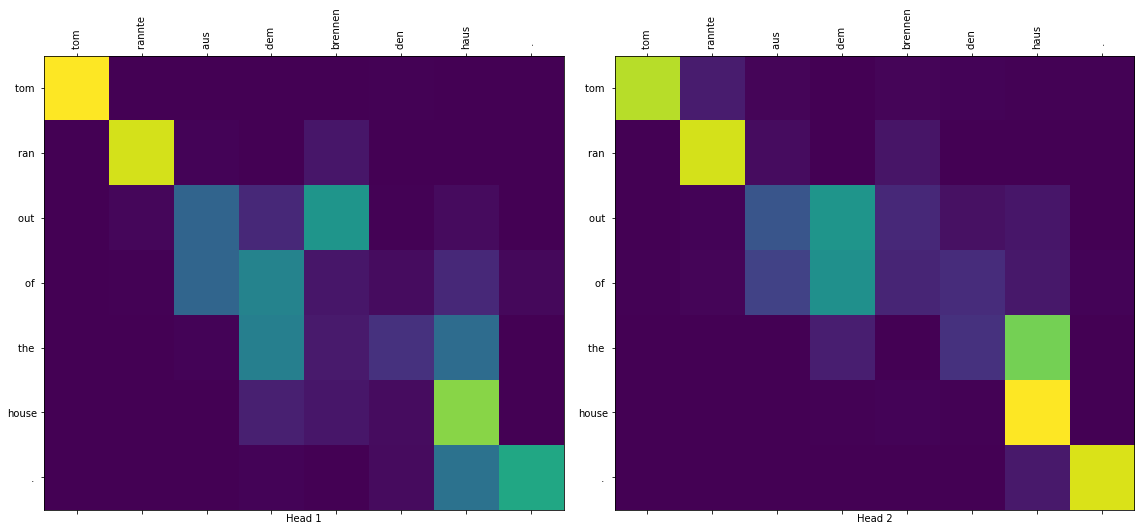

In [0]:
# Plot attention alignment for a prediction
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_attention_weights(summarizer, pred_vectors, layer_name):
    fig = plt.figure(figsize=(16, 8))
    input_text, _ = pred_vectors['preprocessed_text']
    input_sequence = summarizer.vectorizer.encode_input(input_text)
    pred_sequence = pred_vectors['predicted_sequence']
    attention = tf.squeeze(pred_vectors['attention_weights'][layer_name])
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(1, 2, head + 1)
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        fontdict = {'fontsize': 10}
        ax.set_xticks(range(len(input_sequence)))
        ax.set_yticks(range(len(pred_sequence)))
        ax.set_ylim(len(pred_sequence) - 1.5, -0.5)
        ax.set_xticklabels(
            [summarizer.vectorizer.decode_input([i]) for i in input_sequence],
            fontdict=fontdict,
            rotation=90)
        ax.set_yticklabels([summarizer.vectorizer.decode_output([i]) 
                            for i in pred_sequence], fontdict=fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()

pred_vectors = best_summarizer.predict_vectors(
    'Tom rannte aus dem brennenden Haus.', '')
plot_attention_weights(best_summarizer, pred_vectors, 'decoder_layer1_block2')

In [0]:
# Continue training to improve the model and check the BLEU score
from headliner.evaluation import BleuScorer

bleu_scorer = BleuScorer(tokens_to_ignore=[preprocessor.start_token, 
                                           preprocessor.end_token])
trainer.train(best_summarizer, 
              train, 
              num_epochs=30, 
              val_data=test, 
              scorers={'bleu': bleu_scorer})

training an already initialized model...


epoch 0, batch 50, logs: {'loss': 0.5587309688329697}
epoch 0, batch 100, logs: {'loss': 0.556186862885952}
epoch 0, batch 150, logs: {'loss': 0.5621454254786173}
epoch 0, batch 200, logs: {'loss': 0.5577866177260876}
epoch 0, batch 250, logs: {'loss': 0.5561979472637176}

(input) Ich beneide dich sehr. 
(target) I envy you so much. 
(prediction) i envy you . <end>



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



(input) Siehst du es? 
(target) Do you see it? 
(prediction) do you see it ? <end>


(input) Wir haben keinen Tee mehr. 
(target) We're out of tea. 
(prediction) we have no tea . <end>



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



(input) Tom hockte sich hin. 
(target) Tom scrunched down. 
(prediction) tom vomited down . <end>


(input) Wer ist auf Diät? 
(target) Who's dieting? 
(prediction) who's on on facebook ? <end>



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


loss_val improved from None to 1.0644575357437134, saving summarizer to /tmp/summarizer_transformer
epoch 1, batch 300, logs: {'loss': 0.5549514476458232, 'bleu': 0.7600504209318474, 'loss_val': 1.0644575357437134}
epoch 1, batch 350, logs: {'loss': 0.5535186570031302, 'bleu': 0.7600504209318474, 'loss_val': 1.0644575357437134}
epoch 1, batch 400, logs: {'loss': 0.5539342339336872, 'bleu': 0.7600504209318474, 'loss_val': 1.0644575357437134}
epoch 1, batch 450, logs: {'loss': 0.5505019794570075, 'bleu': 0.7600504209318474, 'loss_val': 1.0644575357437134}
finished iterating over dataset, total batches: 467
epoch 1, batch 500, logs: {'loss': 0.5432471603751182, 'bleu': 0.7600504209318474, 'loss_val': 1.0644575357437134}

(input) Ich beneide dich sehr. 
(target) I envy you so much. 
(prediction) i envy you . <end>


(input) Siehst du es? 
(target) Do you see it? 
(prediction) do you see it ? <end>


(input) Wir haben keinen Tee mehr. 
(target) We're out of tea. 
(prediction) we don't have 